In [1]:
import mne
from scipy import signal
import matplotlib.pyplot as plt
import numpy as np
import torch.utils.data as utils
import torch
import torch.nn as nn
import torch.nn.functional as F
from tqdm.contrib import tenumerate
import os
import random
import time

# Seed
seed = 146
torch.manual_seed(seed)
#torch.cuda.manual_seed(seed)
#torch.cuda.manual_seed_all(seed)
np.random.seed(seed)
random.seed(seed)
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True

In [2]:
# Import data
raw = {}

for s in np.arange(9):
    raw[s] = mne.io.read_raw_eeglab(f"dataset3/EEG_VP00{s+1}.set", preload=True)

for s in np.arange(9,12):
    raw[s] = mne.io.read_raw_eeglab(f"dataset3/EEG_VP0{s+1}.set", preload=True)

Reading /home/alexandre.nicolas/dataset3/EEG_VP001.fdt
Reading 0 ... 370879  =      0.000 ...  1854.395 secs...
Reading /home/alexandre.nicolas/dataset3/EEG_VP002.fdt
Reading 0 ... 371665  =      0.000 ...  1858.325 secs...
Reading /home/alexandre.nicolas/dataset3/EEG_VP003.fdt
Reading 0 ... 369461  =      0.000 ...  1847.305 secs...
Reading /home/alexandre.nicolas/dataset3/EEG_VP004.fdt
Reading 0 ... 372518  =      0.000 ...  1862.590 secs...
Reading /home/alexandre.nicolas/dataset3/EEG_VP005.fdt
Reading 0 ... 373995  =      0.000 ...  1869.975 secs...
Reading /home/alexandre.nicolas/dataset3/EEG_VP006.fdt
Reading 0 ... 369976  =      0.000 ...  1849.880 secs...
Reading /home/alexandre.nicolas/dataset3/EEG_VP007.fdt
Reading 0 ... 371495  =      0.000 ...  1857.475 secs...
Reading /home/alexandre.nicolas/dataset3/EEG_VP008.fdt
Reading 0 ... 371533  =      0.000 ...  1857.665 secs...
Reading /home/alexandre.nicolas/dataset3/EEG_VP009.fdt
Reading 0 ... 372365  =      0.000 ...  1861.825 

In [3]:
# Drop EOG channels
n_subject = 12
for s in np.arange(n_subject):
    raw[s] = raw[s].drop_channels('VEOG')

Used Annotations descriptions: ['16', '32']
Used Annotations descriptions: ['16', '32']
Used Annotations descriptions: ['16', '32']
Used Annotations descriptions: ['16', '32']
Used Annotations descriptions: ['16', '32']
Used Annotations descriptions: ['16', '32']
Used Annotations descriptions: ['16', '32']
Used Annotations descriptions: ['16', '32']
Used Annotations descriptions: ['16', '32']
Used Annotations descriptions: ['16', '32']
Used Annotations descriptions: ['16', '32']
Used Annotations descriptions: ['16', '32']


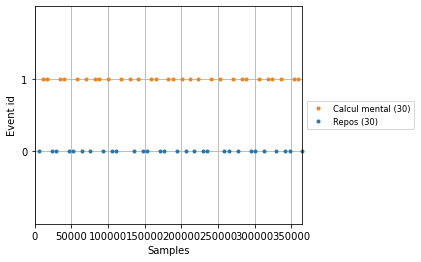

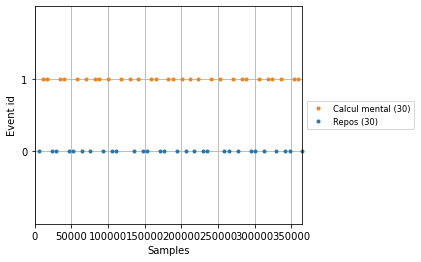

In [ ]:
# Create events & classes
events = {}
for s in np.arange(n_subject):
    events[s] = mne.events_from_annotations(raw[s])
    events[s][0][:,-1] = events[s][0][:,-1] - 1
    
classes = {'Calcul mental' : 1, 'Repos': 0}
# Vizualisation of events
mne.viz.plot_events(events[0][0], event_id=classes)

In [ ]:
# Create epochs
epochs = {}
for s in np.arange(n_subject):
    epochs[s] = mne.Epochs(raw[s], events[s][0], event_id=classes, preload=True, tmin=-2, tmax=10, baseline=None)

In [7]:
# Create labels
n_elec = 22
labels = {}

for k in np.arange(n_subject):
    labels[k] = events[k][0][:,-1]
    
list_labels_epochs = []
for k in np.arange(n_subject):
    list_labels_epochs.append(labels[k])
    
all_labels = np.concatenate(list_labels_epochs)

In [11]:
# Concatenate EEG matrix
epochs_data = {}
for k in np.arange(n_subject):
    epochs_data[k] = epochs[k].get_data()

list_epochs_data = []
for k in np.arange(n_subject):
    list_epochs_data.append(epochs_data[k])

power = np.concatenate(list_epochs_data, axis=0)
n_inputs = power.shape[0]
n_times = power.shape[2]
power.shape

(720, 22, 2401)

In [13]:
# Calculate distance matrix per epoch
import scipy
from sklearn.metrics import mutual_info_score

def calc_MI(x, y, bins=20):

    c_xy = np.histogram2d(x, y, bins)[0]
    mi = mutual_info_score(None, None, contingency=c_xy)

    return mi

def mat_MI(ID_inputs):

    epoch = power[ID_inputs]
    mat = scipy.spatial.distance.pdist(epoch, calc_MI)
    mat = scipy.spatial.distance.squareform(mat)
    return mat

In [14]:
# Calculate distance matrix for MI
start = time.time()
for s in np.arange(n_inputs):
    np.save(f"MI_cm/mat_MI_cm_{s}", mat_MI(s))
end = time.time()
exe = end - start
print(f"TIME : {exe}")

In [15]:
# Load distance matrix
dist_mat = {}
for l in np.arange(n_epochs_total):
    dist_mat[l] = np.load(f"MI_cm/mat_MI_cm_{l}.npy")

In [16]:
# Adjacency matrix
import networkx as nx
def adj_matrix(dist_mat, seuil):

    adj_mat = np.empty((n_elec, n_elec))

    for i in np.arange(n_elec):
        for j in np.arange(n_elec):
            if (dist_mat[i][j] > seuil):
                adj_mat[i][j] = 1
            else:
                adj_mat[i][j] = 0
    return adj_mat

adj_mat = {}
G = {}
s = 0.3

for l in np.arange(n_inputs):
    adj_mat[l] = adj_matrix(dist_mat[l], seuil = s)
    adj_mat[l] = np.triu(adj_mat[l], k=1)
    G[l] = nx.from_numpy_matrix(adj_mat[l])

In [17]:
# Graph degree
def deg_max(G):
    vect_deg = np.empty(n_elec)
    for i, j in G.degree():
        vect_deg[i] = int(j)

    deg_max_G = int(vect_deg.max())
    return deg_max_G

In [18]:
# Score function
def score(ID_inputs, G, V):
    
    epoch = power[ID_inputs]

    deg_max_G = deg_max(G)
    vect_mi = np.empty(len(list(G.neighbors(V))))
    score = 0

    for i in np.arange(len(list(G.neighbors(V)))):
        vect_mi[i] = calc_MI(epoch[V], epoch[list(G.neighbors(V))[i]])

    w = np.empty(n_elec)
    for i in np.arange(n_elec):
        w[i] = epoch[i].mean()

    w = abs(w)
    w = w[list(G.neighbors(V))]

    score = G.degree(V)*(vect_mi*w).sum()/deg_max_G

    return score

In [19]:
# MI method
def selection(budget):

    start = time.time()
    vect_score_G = np.empty((n_inputs, n_elec))

    for i in np.arange(n_inputs):
        for j in np.arange(n_elec):
            vect_score_G[i,j] = score(i, G[i], j)

    mean_score = vect_score_G.mean(axis=0)
    elec_sorted_G = np.flip(np.argsort(mean_score))
    elec_selected_G = elec_sorted_G[0:budget]
    end = time.time()
    exe = end - start
    print(f"TIME : {exe}")

    return elec_selected_G

In [21]:
# Select D(E_k)
def power_select(selection):
    power_sel = np.empty((n_inputs, budget, n_times))
    for l in np.arange(n_inputs):
        for s in np.arange(budget):
            power_sel[l][s] = power[l][selection[s]]
    return power_sel

In [23]:
# Variance
# Sorted by maximum of variance
import statistics as stats

def var_select(budget):
    
    start = time.time()
    inputs_1 = np.where(np.array(all_labels) == 1)[0]
    power_1 = np.swapaxes(power[inputs_1], 0, 1)
    power_1 = torch.Tensor(power_1)
    power_1 = torch.flatten(power_1, start_dim=1, end_dim=2)
    power_1 = np.array(power_1)
    var_1 = np.var(power_1, axis=1)

    var_sorted = np.flip(np.argsort(var_1))
    x = var_sorted[0:budget]
    end = time.time()
    exe = end - start
    print(f"TIME : {exe}")
    
    return x

In [24]:
# K-means and MI
from sklearn.cluster import KMeans

def kmeans_MI(budget, n_clusters):
    
    start = time.time()
    kmeans = {}
    classes_kmeans = {}
    
    for l in np.arange(n_epochs_total):
        list_classes = []
        kmeans[l] = KMeans(n_clusters=n_clusters, random_state=0).fit(dist_mat[l])
        for k in np.arange(n_clusters):
            list_classes.append(np.where(kmeans[l].labels_ == k)[0])
        classes_kmeans[l] = list_classes
        
    dict_score = {}
    for l in np.arange(n_epochs_total):
        vect_score = []
        for k in np.arange(n_clusters):
            list_score = []
            for i in np.arange(len(classes_kmeans[l][k])):
                list_score.append(score(l, G[l], classes_kmeans[l][k][i]))
            vect_score.append(list_score)
        dict_score[l] = vect_score
        
    rep = {}
    for l in np.arange(n_epochs_total):
        list_rep = []
        for k in np.arange(n_clusters):
            list_rep.append(classes_kmeans[l][k][np.where(dict_score[l][k] == np.array(dict_score[l][k]).max())][0])
        rep[l] = list_rep
        
    mat_rep = np.empty((n_epochs_total, n_clusters))
    for l in np.arange(n_epochs_total):
        mat_rep[l] = rep[l]
    mat_rep = mat_rep.astype('int')
    
    elec_sorted = np.flip(np.argsort(np.unique(mat_rep, return_counts=True)[1]))
    elec_selected = elec_sorted[0:budget]
    
    end = time.time()
    exe = end - start
    print(f"TIME : {exe}")
    
    return elec_selected

In [25]:
budget = 10

#MI 03
#array([ 9,  6,  2, 20, 13,  8, 10,  4,  3,  5,  1,  7,  0, 21, 12, 18, 11, 15, 17, 16, 19, 14])

#MI 04
# [ 9,  6,  2,  8,  4,  5,  3, 20,  1, 10]

#MI 06
# [ 9,  6,  2,  8,  4,  3,  5,  1, 10, 20

#MI 07
# [ 9,  6,  2,  8,  4,  3,  5,  1,  7, 10]

# Variance
#var_selection = var_select(budget=budget)

# Tests
# array([ 8,  6,  9, 10,  5,  4, 12,  2,  7, 13, 11,  3,  0, 14,  1, 19, 17, 20, 21, 18, 15, 16])

# Learning
# array([ 6, 10,  9,  8,  4,  7,  2, 13,  3, 14, 11,  5, 12, 15,  0, 21,  1, 16, 17, 19, 18, 20])

# MI
#MI_selection = selection(budget)

#K-means
#selection_kmeans = kmeans_MI(budget=22, n_clusters=5)

# Hybrid
# [5, 11, 14, 21, 7, 3, 8, 6, 12, 1]
#hybrid_selection = [5, 11, 14, 21,  7, 3,  8, 6,  12, 1]

#power_selection = power_select(selection)
#power_selection.shape

TIME : 0.24564433097839355


array([16, 15, 14,  8, 10, 11,  6, 17,  5,  9])

In [27]:
del epochs

In [28]:
# Define y vector for binary cross entropy
def labels_input(n_subject):

    labels = {}
    for i in np.arange(n_inputs):
        labels[f"id_input_{i}"] = all_labels[i]
        if (labels[f"id_input_{i}"] == 0):
            labels[f"id_input_{i}"] = torch.tensor([1,0])
        else:
            labels[f"id_input_{i}"] = torch.tensor([0,1])
    
    return labels

labels_inp = labels_input(n_subject)

In [29]:
# Split train, validation and test
from sklearn.model_selection import train_test_split
ID = np.arange(n_epochs_total)
ID_train, ID_val_test = train_test_split(ID, train_size=0.7, shuffle=True, random_state=37, stratify = all_labels)
ID_val, ID_test = train_test_split(ID_val_test, train_size=0.5, shuffle=True, random_state=37, stratify = all_labels[ID_val_test])
ID_test.shape

(109,)

In [30]:
# Create dataset 
class Dataset(torch.utils.data.Dataset):
      'Characterizes a dataset for PyTorch'
      def __init__(self, list_ID, labels, power):
            'Initialization'
            self.labels = labels
            self.list_ID = list_ID
            self.power = power

      def __len__(self):
            'Denotes the total number of samples'
            return len(self.list_ID)

      def __getitem__(self, index):
            'Generates one sample of data'
            # Select sample
            ID = self.list_ID[index]
            #ID = self.ID_pic[index]
        
            # Load data and get label
            X = self.power[ID]
            y = self.labels[f"id_input_{ID}"]

            return X, y

In [31]:
# Dataset and dataloader
params = {'batch_size': 8, 'shuffle': True}

train_set = Dataset(ID_train, labels_inp, power_selection)
train_dataloader = torch.utils.data.DataLoader(train_set, **params)

val_set = Dataset(ID_val, labels_inp, power_selection)
val_dataloader = torch.utils.data.DataLoader(val_set, **params)

test_set = Dataset(ID_test, labels_inp, power_selection)
test_dataloader = torch.utils.data.DataLoader(test_set, **params)

NameError: name 'power_selection' is not defined

In [ ]:
# Use GPUs
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
# CNN
class CNN(nn.Module):

    def __init__(self, pad1, pad2, pad3, pad4):

        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=(2,2), padding=pad1)
        self.conv2 = nn.Conv2d(32, 32, kernel_size=(2,2), padding=pad2)
        self.conv3 = nn.Conv2d(32, 32, kernel_size=(2,2), padding=pad3)
        self.conv4 = nn.Conv2d(32, 32, kernel_size=(2,2), padding=pad4)
        self.BatchNorm1 = nn.BatchNorm2d(32, eps=1e-05, momentum=0.01, affine=True, track_running_stats=False)
        self.BatchNorm2 = nn.BatchNorm2d(32, eps=1e-05, momentum=0.01, affine=True, track_running_stats=False)
        self.BatchNorm3 = nn.BatchNorm2d(32, eps=1e-05, momentum=0.01, affine=True, track_running_stats=False)
        self.BatchNorm4 = nn.BatchNorm2d(32, eps=1e-05, momentum=0.01, affine=True, track_running_stats=False)
        #32*300
        self.fc1 = nn.Linear(32*300, 300)
        self.fc2 = nn.Linear(300, 100)
        self.fc3 = nn.Linear(100, 50)
        self.fc4 = nn.Linear(50, 20)
        self.fc5 = nn.Linear(20, 2)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        #print(x.shape)
        x = self.BatchNorm1(x)
        x = F.max_pool2d(x, kernel_size=2)
        #print(x.shape)
        x = F.relu(self.conv2(x))
        #print(x.shape)
        x = self.BatchNorm2(x)
        x = F.max_pool2d(x, kernel_size=2)
        #print(x.shape)
        x = F.relu(self.conv3(x))
        #print(x.shape)
        x = self.BatchNorm3(x)
        x = F.max_pool2d(x, kernel_size=2)
        #print(x.shape)
        x = F.relu(self.conv4(x))
        #print(x.shape)
        x = self.BatchNorm4(x)
        x = torch.flatten(x, start_dim=1, end_dim=3)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.relu(self.fc4(x))
        x = self.fc5(x)
        x = self.softmax(x)

        return x

# Zero-padding
if (budget in [1,2]):
    cnn = CNN((4,1), "same", "same", "same")
elif (budget in [3,4]):
    cnn = CNN((3,1), "same", "same", "same")
elif (budget in [5,6]):
    cnn = CNN((2,1), "same", "same", "same")
elif (budget in [7,8]):
    cnn = CNN((1,1), "same", "same", "same")
elif (budget in np.arange(9,15)):
    cnn = CNN((0,1), "same", "same", "same")
elif (budget in np.arange(15,24)):
    cnn = CNN((0,1), (0,1), (0,0), "same")
    
cnn = cnn.to(device)

In [ ]:
# Add dimension to EEG matrix to have tensor of size (1, n_E, n_t)
def correct_input(inputs):
    inputs = np.array(inputs)
    inputs = np.expand_dims(inputs, axis = 1)
    inputs = torch.from_numpy(inputs)
    inputs = inputs.float()
    return inputs

In [ ]:
# Validation function for early stopping
def validation(model, val_dataloader, loss_function):
    model.eval()
    loss_total = 0

    # Test validation data
    with torch.no_grad():
        for i, data in enumerate(val_dataloader):
            inputs, labels = data
            inputs = correct_input(inputs)
            inputs, labels = inputs.to(device), labels.to(device)
            inputs = inputs.float()
            labels = labels.float()
            outputs = model(inputs)
            loss = loss_function(outputs, labels)
            loss_total += loss.item()

    return loss_total / len(val_dataloader)

In [ ]:
# Training function
def train(model, epochs, optimizer, loss_function, train_dataloader, val_dataloader):

    last_loss = 100
    patience = 20
    trigger_times = 0
    loss_train = []
    loss_val = []

    for epoch in range(1, epochs+1):  # loop over the dataset multiple times
        model.train()
        running_loss = 0.0
        for i, data in enumerate(train_dataloader):
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data
            inputs = correct_input(inputs)
            inputs, labels = inputs.to(device), labels.to(device)
            inputs = inputs.float()
            labels = labels.float()
            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = model(inputs)
            loss = loss_function(outputs, labels)
            loss.backward()
            optimizer.step()
            #print(loss)

            # Show progress
            running_loss += loss.item()
            if i % 5 == 0 or i == len(train_dataloader):
                print('[{}/{}, {}/{}] loss: {:.8}'.format(epoch, epochs, i, len(train_dataloader), loss.item()))
            print("running lose :", running_loss)
        loss_train.append(running_loss / len(train_dataloader))

        # Early stopping
        current_loss = validation(model, val_dataloader, loss_function)
        print('The Current Loss:', current_loss)
        loss_val.append(current_loss)

        if current_loss > last_loss:
            trigger_times += 1
            print('Trigger Times:', trigger_times)

            if trigger_times >= patience:
                print('Early stopping!\nStart to test process.')
                return model

        else:
            print('trigger times: 0')
            trigger_times = 0

        last_loss = current_loss
        
    return model, loss_train, loss_val

In [ ]:
# Evaluation
from sklearn.metrics import confusion_matrix
import pandas as pd

def test(model, test_dataloader):
    y_true = np.empty(0)
    y_pred = np.empty(0)

    # since we're not training, we don't need to calculate the gradients for our outputs
    with torch.no_grad():
        for data in test_dataloader:
            inputs, labels = data
            inputs = correct_input(inputs)
            inputs, labels = inputs.to(device), labels.to(device)
            inputs = inputs.float()
            labels = torch.Tensor.cpu(labels)
            classes = np.argmax(labels, axis=1)
            
            y_true = np.concatenate((y_true, classes))
            # calculate outputs by running images through the network
            outputs = model(inputs)
            outputs = torch.Tensor.cpu(outputs)
            outputs = outputs.detach().numpy()

            # the class with the highest energy is what we choose as prediction
            predicted = np.argmax(outputs, axis=1)
            
            y_pred = np.concatenate((y_pred, predicted))
            
        tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()

        accuracy = (tn + tp) / (tn + fp + fn + tp) * 100
        specificity = tn / (tn+fp) * 100
        sensitivity = tp / (tp+fn) * 100
        d = {'Vrai calcul': [tp, fn], 'Vrai repos': [fp, tn]}
        m_conf = pd.DataFrame(data=d, index=['Calcul prédit', 'Repos prédit'])
        
    return accuracy, sensitivity, specificity, m_conf

In [ ]:
# Training with several iteration
import torch.optim as optim
import time

# Seed
seed = 13
torch.manual_seed(seed)
#torch.cuda.manual_seed(seed)
#torch.cuda.manual_seed_all(seed)
np.random.seed(seed)
random.seed(seed)
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True

n = 10
list_acc = []
i = 0

start = time.time()
while i < n:
    
    if (budget in [1,2]):
        cnn = CNN((4,1), "same", "same", "same")
    elif (budget in [3,4]):
        cnn = CNN((3,1), "same", "same", "same")
    elif (budget in [5,6]):
        cnn = CNN((2,1), "same", "same", "same")
    elif (budget in [7,8]):
        cnn = CNN((1,1), "same", "same", "same")
    elif (budget in np.arange(9,15)):
        cnn = CNN((0,1), "same", "same", "same")
    elif (budget in np.arange(15,24)):
        cnn = CNN((0,1), (0,1), (0,0), "same")
    
    cnn = cnn.to(device)
    
    dataset = "CM"
    criterion = nn.BCELoss()
    lr = 0.001
    it = 130
    optimizer = optim.SGD(cnn.parameters(), lr=lr) 
    cnn_train, loss_train, loss_val = train(cnn, it, optimizer, criterion, train_dataloader, val_dataloader)
    acc, sens, spe, m_conf = test(cnn_train, test_dataloader)
    list_acc.append(acc)
    i += 1
    
end = time.time()
exe = end - start
print(f"Temps d'execution : {exe}")

In [ ]:
# Mean of accuracy
np.array(list_acc).mean()

In [ ]:
# Plot loss train and loss validation, accuracy, sensitivity and specificity
plt.figure(0)
plt.plot(loss_train, label="Erreur d'apprentissage")
plt.plot(loss_val, label="Erreur de validation")
plt.legend()
plt.figtext(0.1, 0, f"Accuracy : {acc} %")
plt.figtext(0.1, -0.05, f"Sensitivité : {sens} %")
plt.figtext(0.1, -0.1, f"Spécificité : {spe} %")
plt.figtext(0.1, -0.25, f"         {m_conf}".replace("Calcul prédit", "Calcul prédit").replace("Repos prédit ", "Repos prédit").replace("45", "45   ").replace("10", "10   "))
plt.figtext(0.6, 0, f"Jeu de données : {dataset}")
plt.figtext(0.6, -0.05, f"Nombre d'entrées : {n_inputs}")
plt.figtext(0.6, -0.1, f"Nombre d'itérations : {it}")
plt.figtext(0.6, -0.15, f"Taille du batch : {params['batch_size']}")
plt.figtext(0.6, -0.2, f"Budget d'électrodes : {budget}")
plt.figtext(0.6, -0.25, f"Taux d'apprentissage : {lr}")
plt.savefig(f"graph_{dataset}_lr_{lr}_batch_{params['batch_size']}_budget_{budget}.pdf", bbox_inches = 'tight')

In [ ]:
# Hybrid method
# Seed
seed = 123
torch.manual_seed(seed)
#torch.cuda.manual_seed(seed)
#torch.cuda.manual_seed_all(seed)
np.random.seed(seed)
random.seed(seed)
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True

def hybrid(budget, power):
    
    E = np.arange(n_elec)
    E_k = []

    while len(E_k) < budget:
        
        start = time.time()
        #vect_acc = np.empty((len(np.delete(E, E_k))))
        acc_min = 101
        e_min = 30

        for l in np.delete(E, E_k):

            power_unif = power.copy()

            for k in np.arange(n_epochs_total):
                for j in E_k:
                    power_unif[k][j] = np.random.uniform(power.min(), power.max(), n_times)

            for k in np.arange(n_epochs_total):
                power_unif[k][l] = np.random.uniform(power.min(), power.max(), n_times)

            test_set = Dataset(ID_test, labels_inp, power_unif)
            test_dataloader = torch.utils.data.DataLoader(test_set, **params)
            acc, sens, spe, m_conf = test(cnn_train, test_dataloader)
            #vect_acc[l] = acc
            if (acc < acc_min):
                acc_min = acc
                e_min = l
        
        E_k.append(e_min)

        print(f"LENGTH E_K : {len(E_k)}")
        print(E_k)
        
        end = time.time()
        exe = end - start
        print(f"TIME : {exe}")
                
    return E_k

In [ ]:
elec_selected = hybrid(budget=10, power=power_selection)

In [ ]:
# Test method
def selection_by_test(budget, power, it, method):
    
    start = time.time()
    mat_acc = np.empty((n_elec, it))

    if (method == 'unif'):
        for l in np.arange(n_elec):
            power_unif = power.copy()
            for i in np.arange(it):
                np.random.seed(i)
                for k in np.arange(n_epochs_total):
                    #power_unif[k][l] = np.zeros(n_times)
                    power_unif[k][l] = np.random.uniform(power.min(), power.max(), n_times)

                test_set = Dataset(ID_test, labels_inp, power_unif)
                test_dataloader = torch.utils.data.DataLoader(test_set, **params)
                acc, sens, spe, m_conf = test(cnn_train, test_dataloader)
                mat_acc[l,i] = acc
                print(l,i)
    
    elec_sorted = np.argsort(np.mean(mat_acc, axis=1))
    elec_selected = elec_sorted[0:budget]
    end = time.time()
    exe = end - start
    print(f"TIME : {exe}")
                
    return mat_acc, power_unif, elec_selected

In [ ]:
#mat_acc, power_unif, elec_selected = selection_by_test(budget=budget, power=power_selection, it=5, method='unif')

In [ ]:
# Learning method
import torch.optim as optim

def selection_by_learning(budget, power, method):
    
    start = time.time()
    vect_acc = np.empty((n_elec))
    
    for l in np.arange(n_elec):
        power_unif = power.copy()
        for k in np.arange(n_epochs_total):
            if (method == 'unif'):
                power_unif[k][l] = np.random.uniform(power.min(), power.max(), n_times)

        cnn = CNN((0,1), (0,1), (0,0), "same")
        cnn = cnn.to(device)

        train_set = Dataset(ID_train, labels_inp, power_unif)
        train_dataloader = torch.utils.data.DataLoader(train_set, **params)

        val_set = Dataset(ID_val, labels_inp, power_unif)
        val_dataloader = torch.utils.data.DataLoader(val_set, **params)

        test_set = Dataset(ID_test, labels_inp, power_unif)
        test_dataloader = torch.utils.data.DataLoader(test_set, **params)
        
        criterion = nn.BCELoss()
        lr = 0.001
        optimizer = optim.SGD(cnn.parameters(), lr=lr) 

        cnn_train, loss_train, loss_val = train(cnn, 130, optimizer, criterion, train_dataloader, val_dataloader)
        acc, sens, spe, m_conf = test(cnn_train, test_dataloader)

        vect_acc[l] = acc
        
        print(f"END TRAINING {l}")
    
    elec_sorted = np.argsort(vect_acc)
    elec_selected = elec_sorted[0:budget]
    end = time.time()
    exe = end - start
    print(f"TIME : {exe}")
    
    return vect_acc, elec_selected

In [ ]:
vect_acc, elec_selected = selection_by_learning(budget=budget, power=power_selection, method='unif')

In [32]:
# Vizualisation of electrods
import plotly.express as px 
import pandas as pd
import networkx as nx

montage = raw[0].get_montage()

dict_elec = {}
for i in np.arange(n_elec):
    dict_elec[montage.ch_names[i]] = i

elec_loc = np.empty((n_elec, 3))
for key, val in montage.get_positions()['ch_pos'].items():
    elec_loc[dict_elec[key]] = val
    
def vis_elec(list_elec):

    df_elec = pd.DataFrame(elec_loc, columns = ['x', 'y', 'z']) 
    selected = pd.DataFrame(index=np.arange(n_elec), columns=['Selected'])

    for i in np.arange(n_elec):
        if (i in list_elec):
            selected['Selected'][i] = 'Yes'
        else:
            selected['Selected'][i] = 'No'

    df_elec_selected = pd.concat([df_elec, selected], axis=1)

    fig = px.scatter_3d(df_elec_selected, x = 'x', y = 'y',  z = 'z', opacity = 0.5, color="Selected", color_discrete_map={'Yes' : 'red', 'No' : 'blue'})
    fig.write_html(f"subject_0_all_epoch_budget_{len(list_elec)}"+".html")

    return fig.show()

vis_elec(selection)

In [ ]:
# Electrods selected
np.array(montage.ch_names)[np.array([16, 15, 14,  8, 10, 11,  6, 17,  5,  9])]
# array(['POO1', 'P3', 'P7', 'AFF1h', 'Cz', 'Pz', 'F4', 'POO2', 'AFF6h', 'AFF2h']